# Assignment 3: Object Detection Model - YOLOv3

### Introduction to **nn.ModuleList()**
[`nn.ModuleList()`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) is a container in PyTorch used to manage sub-modules. It allows for iteration, access, and serialization of sub-modules, and also facilitates passing them to GPUs for accelerated computations.

To add sub-modules to an `nn.ModuleList()`, you can use the `append()` method. This method adds an `nn.Module` object to the end of the `nn.ModuleList()`, and can accept one or more `nn.Module` objects as parameters.

Here's a simple example demonstrating how to use `nn.ModuleList()` and `append()` to add three simple fully-connected layers to a neural network:

```python
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(10, 20))
        self.layers.append(nn.Linear(20, 30))
        self.layers.append(nn.Linear(30, 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
```

In the above code, we first define a class called `MyModel`, which inherits from `nn.Module` and defines an `nn.ModuleList()` named layers. We then use the `append()` method to add three `nn.Linear` objects to layers, each set as a linear transformation layer from $10 \rightarrow 20$, $20 \rightarrow 30$, and $30 \rightarrow 1$, respectively. Finally, we define a `forward()` method that iterates through each layer in layers using a `for` loop and performs a `forward` pass.

Overall, the combination of `nn.ModuleList()` and the `append()` method allows us to conveniently manage and construct neural networks containing multiple sub-modules.

In [3]:
import torch
import torch.nn as nn

training = __name__ == '__main__'

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(10, 20))
        self.layers.append(nn.Linear(20, 30))
        self.layers.append(nn.Linear(30, 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

if training:    
    model = MyModel()
    print(model)

MyModel(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=1, bias=True)
  )
)


### Import packages and fix seed



In [5]:
# DO NOT MODIFY THIS CELL

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
import testing.config as config
from testing.utils import fix_seed, check_class_accuracy, \
    cells_to_bboxes, non_max_suppression, plot_image, YOLODataset

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  !jar xvf 'Detection_weights_dataset.zip'

  created: PEDESTRIAN/
 inflated: __MACOSX/._PEDESTRIAN
 inflated: PEDESTRIAN/.DS_Store
 inflated: __MACOSX/PEDESTRIAN/._.DS_Store
  created: PEDESTRIAN/images/
  created: PEDESTRIAN/labels/
 inflated: PEDESTRIAN/pedestrain_film_test.csv
 inflated: PEDESTRIAN/pedestrain_film.csv
 inflated: PEDESTRIAN/pedestrain_2_sample.csv
 inflated: PEDESTRIAN/images/V011_1127.jpg
 inflated: PEDESTRIAN/images/V011_1133.jpg
 inflated: PEDESTRIAN/images/V011_936.jpg
 inflated: PEDESTRIAN/images/V011_1090.jpg
 inflated: PEDESTRIAN/images/V011_1084.jpg
 inflated: PEDESTRIAN/images/V011_922.jpg
 inflated: PEDESTRIAN/images/V011_1053.jpg
 inflated: PEDESTRIAN/images/V011_1047.jpg
 inflated: PEDESTRIAN/images/V011_1286.jpg
 inflated: PEDESTRIAN/images/V011_1279.jpg
 inflated: PEDESTRIAN/images/V011_1251.jpg
 inflated: PEDESTRIAN/images/V011_1245.jpg
 inflated: PEDESTRIAN/images/V011_1244.jpg
 inflated: PEDESTRIAN/images/V011_1250.jpg
 inflated: PEDESTRIAN/images/V011_1278.jpg
 inflated: PEDESTRIAN/images/V0

## Exercise 1: Build YOLOv3 architecture
The YOLOv3 model consists of three main parts: the Darknet-53 feature extraction network, multiscale feature fusion, and output network.

1. Darknet-53 feature extraction network: A 53-layer convolutional neural network used to extract feature information from the input image. This network uses residual blocks and shortcut techniques to improve the accuracy and efficiency of feature extraction.

2. Multiscale feature fusion: YOLOv3 uses three different-sized feature maps to detect objects, which come from different depth layers. By combining these feature maps with anchors of different sizes, objects of various sizes and ratios can be detected.

3. Output network: The YOLOv3 output network consists of three detection layers of different scales, each using a convolutional neural network to output bounding boxes, object confidence, and class probabilities. Additionally, non-maximum suppression (NMS) is used to eliminate redundant detection results.

**Darknet-53 architecture**   
<center>

![Alt text](image/darknet_53_table.png "a title")
</center>

A `CONFIG` is provided that describes the entire architecture of YOLOv3. The elements of the `CONFIG` include tuples, lists, and strings, which correspond to different types of layers.  

**Tuple** is structured by and signifies a convolutional block (out_channels, kernel_size, stride)  
**List** is structured by and signifies a residual block ["Residual"/`ResidualBlock()`, number_of_repeat]  
**"Residual"** indicating a residual block followed by the number of repeats  
**"Scale"** is for a scale prediction block and computing the yolo loss  
**"Upsample"** is for upsampling the feature map

Every convolutional layer shares a same convolution.

In [6]:
# DO NOT MODIFY THIS CELL

CONFIG = [
    (32, 3, 1),
    (64, 3, 2),
    ["Residual", 1],
    (128, 3, 2),
    ["Residual", 2],
    (256, 3, 2),
    ["Residual", 8],
    # first route from the end of the previous block
    (512, 3, 2),
    ["Residual", 8], 
    # second route from the end of the previous block
    (1024, 3, 2),
    ["Residual", 4],
    # until here is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "Scale",
    (256, 1, 1),
    "Upsample",
    (256, 1, 1),
    (512, 3, 1),
    "Scale",
    (128, 1, 1),
    "Upsample",
    (128, 1, 1),
    (256, 3, 1),
    "Scale",
]

With the help of the diagram, we can have a better understanding of the relationship between the architecture of YOLOv3 and its `CONFIG`, and we can also have a clearer idea of when to use the classes provided by us.
<center>

![Alt text](image/yolov3_custom.jpg "a title")
</center>

The following three classes correspond to the three subregions as shown in the YOLOv3 architecture diagram (red).  

1. The `CNNBlock()`: corresponds to the DBL in the diagram, and through the parameter bn_act, we can control whether to add Batch Normalization and Leaky ReLU after the convolutional layer.  

2. The `ResidualBlock()` corresponds to the residual unit in the diagram, and through the parameter use_residual, we can control whether to add the residual connection. Also, we can control the number of repeats of the res unit.  

3. The `ScalePrediction()` corresponds to the subregion before output in the diagram, and through the parameter num_classes, we can determine the number of classes to be predicted.  

In [7]:
# DO NOT MODIFY THIS CELL

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act
        
    def forward(self, x):
        if self.use_bn_act:
            return self.leaky_relu(self.bn(self.conv(x)))
        else:
            return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]
        self.use_residual = use_residual
        self.num_repeats = num_repeats
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + x if self.use_residual else layer(x)
        
        return x
    
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(2 * in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1)
        )
        self.num_classes = num_classes
        
    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )   # output shape: (batch_size, 3, grid_size, grid_size, num_classes + 5)
        

Please use the three sub-modules mentioned above to build the YOLOv3 architecture by iterating through the `CONFIG`.  
Follow the given `if` conditions and complete the `forward` and `_create_conv_layers` functions. Think about how to connect them in the correct way in `forward`.  
Replace the `pass` statement with your code.  
<font color='red'> **Hint**: finish `_create_conv_layers()` first and try to create the flow and connection within `forward()`. Remember to update the `in_channels` after each layer. </font> 

In [8]:
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=80):
        super(YOLOv3, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels
        
        for module in CONFIG:
        # BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        # For every if statement, put your answer in place of pass            
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels 

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))
            
            elif isinstance(module, str):
                if module == "Scale":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module == "Upsample":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3
                    
        # END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<               
        return layers
    
    def forward(self, x):
        outputs = []
        route_connections = []  # for skip connections
        
        for layer in self.layers:
        # BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        # For every if statement, put your answer in place of pass          
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue
            
            x = layer(x) # pass the input through the layer
            
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
                
        # END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        return outputs

## Exercise 2: Implement the loss and train model
### Before calculating the loss, we need to first calculate the IoU.  
When evaluating the performance of object detection and segmentation models, Intersection over Union (IoU) is a commonly used metric.  
IoU measures the ratio of the overlap between the predicted and ground-truth objects, with the formula:
$$
IoU = \frac{intersection\; area}{union\; area + 10^{-6}}
$$
To avoid division by zero errors, $10^{-6}$ is added.  

The formula is visualised in the graph bellow.  
<center>

![Alt text](image/iou.jpeg "a title")
</center>

In [9]:
def iou(boxes_preds, boxes_labels):
    """
    :param boxes_preds (tensor): shape (num_of_preds, 4), where 4 is (x, y, w, h)
    :param boxes_labels (tensor): shape (num_of_labels, 4), where 4 is (x, y, w, h)
    """ 
    
    # BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    

    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    iou = intersection / (box1_area + box2_area - intersection + 1e-6)
    # END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    
    return iou.detach()

### Then we can move on the loss calculation.  

First we will form two binary tensors signifying where in what cells using which anchors that have objects assigned to them and not. 
```python      
obj = target[..., 0] == 1 
noobj = target[..., 0] == 0 
```
The reason for not only using one of these is that we, in the data loading, assign the anchors that should be ignored to -1. 

### 1. No object loss
For the anchors in all cells that do not have an object assigned to them, i.e. all indices that are set to one in `noobj`, we want to incur loss only for their object score. The target will be all zeros since we want these anchors to predict an object score of zero and we will apply a sigmoid function to the network outputs and use a binary crossentropy loss. 

The no object loss is defined as
$$
\begin{aligned} 
L_{noobj} &= \frac{1}{N \sum_{a, i,j} \mathbb{1}_{a\ i\ j}^{\text {noobj }}} \sum_{n=1}^N \sum_{a,i,j \in \mathbb{1}_{a\ i \ j}^{\text {noobj }}} BCE \left ( y_{n,a,i,j}^{obj}, \sigma\left(t_{n,a,i,j}^{obj}\right)\right) \\
&=\frac{1}{N \sum_{a, i,j} \mathbb{1}_{a\ i\ j}^{\text {noobj }}} \sum_{n=1}^N \sum_{a,i,j \in \mathbb{1}_{a\ i \ j}^{\text {noobj }}} -\left[y_{n,a,i,j}^{obj} \cdot \log \sigma\left(t_{n,a,i,j}^{obj}\right)+\left(1-y_{n,a,i,j}^{obj}\right) \cdot \log \left(1-\sigma(t_{n,a,i,j}^{obj})\right)\right],
\end{aligned}
$$

where $N$ is the batch size, $i,\ j$ signifies the cell where and $a$ the anchor index and $\mathbb{1}_{a\ i\ j}^{\text {noobj }}$ is a binary tensor with ones on anchors not assigned to an object. The output from the network is denoted $t$ and the target $y$ and $\sigma$ is the sigmoid function given by 

$$
\sigma(x) = \frac{1}{1+e^{-x}}.
$$

### 2. Object loss

In the code we will convert the model predictions to bounding boxes according to the formulas in the paper
$$
\begin{array}{l}
b_{x}=\sigma\left(t_{x}\right) \\
b_{y}=\sigma\left(t_{y}\right) \\
b_{w}=p_{w} e^{t_{w}} \\
b_{h}=p_{h} e^{t_{h}},
\end{array} \\
$$
where $p_w$ and $p_h$ are the anchor box dimensions, and ($b_x, b_y, b_w, b_h$) is the resulting bounding box relative to the cell. We will then calculate the intersection over union with the target that we defined in the dataset class. Lastly, as in the no object loss above, apply the binary cross entropy loss between the object score predictions and the calculated intersection over union. Note that the loss will only be applied to the anchors assigned to a target bounding box signified by indexing by `obj`.  

The mathematical formula will be similar to the one above 
$$
L_{obj}= \frac{1}{N \sum_{a, i,j} \mathbb{1}_{a\ i\ j}^{\text {obj }}} \sum_{n=1}^N \sum_{a,i,j \in \mathbb{1}_{a\ i \ j}^{\text {obj }}} BCE \left ( \hat{y}_{n,a,i,j}^{obj}, \sigma\left(t_{n,a,i,j}^{obj}\right)\right)
$$
with 
$$ \hat{y} = IOU(y^{box}, b), $$
where $b$ is the bounding box computed above and $ \mathbb{1}_{a\ i\ j}^{\text {obj }}$ corresponds to the binary tensor with ones for the anchors assigned to a target bounding box. 

### 3. Box coordinates loss
For the box coordinates we will simply use a mean squared error loss in the positions where there actually are objects. All predictions where there is no corresponding target bounding box will be ignored. We will apply a sigmoid function to the $x$
and $y$ coordinates to make sure that they are between \[0,1\] but instead of converting the widths and heights as above we want to compute the ground truth value $\hat{t}$ that the network should predict. We find it by inverting the formula above for the bounding boxes
$$ 
\begin{aligned}
\hat{t}_w &= \log (y_w / p_w) \\
\hat{t}_h &= \log (y_h / p_h),
\end{aligned}
$$
where the $y_w$ and $y_h$ are the target width and height. We will then apply the mean squared error loss between the targets and predictions.  

The formula is given by
$$
L_{box} = \frac{1}{N \sum_{a, i,j} \mathbb{1}_{a\ i\ j}^{\text {obj }}} \sum_{n=1}^N \sum_{a,i,j \in \mathbb{1}_{a\ i \ j}^{\text {obj }}}  \left(\sigma(t^x_{n,a,i,j}) - y^x_{n,a,i,j} \right)^2 +
\left(\sigma(t^y_{n,a,i,j}) - y^y_{n,a,i,j} \right)^2 +
\left(t^w_{n,a,i,j} - \hat{t}^w_{n,a,i,j} \right)^2 +
\left(t^h_{n,a,i,j} - \hat{t}^h_{n,a,i,j} \right)^2, 
$$
where $\hat{t}^*$ is the ground truth labels for what actual values the model should predict.

### 4. Class loss
We will only incur loss for the class predictions where there actually is an object. Our implementation differs slightly from the paper's in the case of a class loss and we will use a cross entropy loss to compute the class loss. This assumes that each bounding box only has one label. The YOLOv3 motivates that it does not want to have this limitation and instead uses an binary cross entropy such that several labels can be assigned to a single object e.g. woman and person. 

The formula is given by
$$ 
L_{class} = \frac{1}{N \sum_{a, i,j} \mathbb{1}_{a\ i\ j}^{\text {obj }}} \sum_{n=1}^N \sum_{a,i,j \in \mathbb{1}_{a\ i \ j}^{\text {obj }}} -\log \left(\frac{\exp (t_{n, a, i,j}^{c})}{\sum_{k} \exp (t_{n, a, i,j}^k)}\right),
$$
where $t_{n, a, i,j}^{c}$ is the prediction for the correct class $c$. 

### **Total loss**
$$ L= \lambda_{noobj} L_{noobj} + \lambda_{obj} L_{obj} + \lambda_{box} L_{box} + \lambda_{class} L_{class} $$


Please utilize the `iou()` you just defined and fill up the missing part in `object_loss` calculation.  
Build up the `YoloLoss` here.

In [10]:
class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 1
        self.lambda_obj = 10
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        """
        :param predictions: output from model of shape: (batch size, anchors on scale , grid size, grid size, 5 + num classes)
        :param target: targets on particular scale of shape: (batch size, anchors on scale, grid size, grid size, 6)
        :param anchors: anchor boxes on the particular scale of shape (anchors on scale, 2)
        :return: returns the loss on the particular scale
        """

        # Check where obj and noobj (we ignore if target == -1)
        # Here we check where in the label matrix there is an object or not
        obj = target[..., 0] == 1  # in paper this is Iobj_i
        noobj = target[..., 0] == 0  # in paper this is Inoobj_i
        
        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #
        # The indexing noobj refers to the fact that we only apply the loss where there is no object
        no_object_loss = self.bce(
            (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
        )


        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #
        # Here we compute the loss for the cells and anchor boxes that contain an object
        # Reshape anchors to allow for broadcasting in multiplication below
        anchors = anchors.reshape(1, 3, 1, 1, 2)
        
        # BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = iou(box_preds[obj], target[..., 1:5][obj])
        # END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        
        # Only incur loss for the cells where there is an objects signified by indexing with obj
        object_loss = self.bce((predictions[..., 0:1][obj]), (ious * target[..., 0:1][obj]))
        
        
        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #
        # apply sigmoid to x, y coordinates to convert to bounding boxes
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3]) 
        # to improve gradient flow we convert targets' width and height to the same format as predictions
        target[..., 3:5] = torch.log(
            (1e-16 + target[..., 3:5] / anchors)
        ) 
        # compute mse loss for boxes
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])


        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #
        # here we just apply cross entropy loss as is customary with classification problems
        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
        )
        
        
        # BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        total_loss = self.lambda_class*class_loss + self.lambda_box*box_loss + self.lambda_obj*object_loss + self.lambda_noobj*no_object_loss
        
        # END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        
        return total_loss

## Build train function and load data

### Let us define a training loop

In [11]:
# DO NOT MODIFY THIS CELL

def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors):
    loop = tqdm(train_loader, leave=True)
    losses = []
    for x, y in loop:
        x = x.to(config.DEVICE)
        y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )
            
        losses.append(loss.item())
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)

### Load the provided Caltech Pedestrian data

In [12]:
# DO NOT MODIFY THIS CELL
if training:
    train_csv_path = config.DATASET + "/pedestrain_film.csv"
    test_csv_path = config.DATASET + "/pedestrain_film_test.csv"

    IMAGE_SIZE = config.IMAGE_SIZE

    train_dataset = YOLODataset(
        train_csv_path,
        transform=config.train_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        img_dir=config.IMG_DIR,
        label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )
    test_dataset = YOLODataset(
        test_csv_path,
        transform=config.test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        img_dir=config.IMG_DIR,
        label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

### Let us look at a few samples

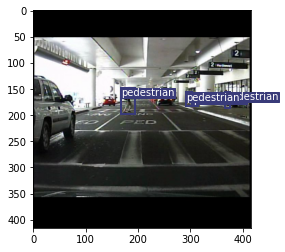

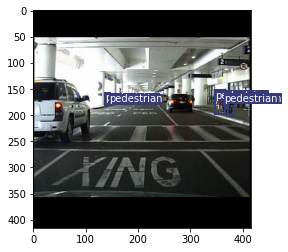

In [13]:
def show_sample():
    anchors = config.ANCHORS

    transform = config.test_transforms

    dataset = YOLODataset(
        "PEDESTRIAN/pedestrain_2_sample.csv",
        "PEDESTRIAN/images/",
        "PEDESTRIAN/labels/",
        S=[13, 26, 52],
        anchors=anchors,
        transform=transform,
        C=1,
    )
    S = [13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
    for x, y in loader:
        boxes = []

        for i in range(y[0].shape[1]):
            anchor = scaled_anchors[i]
            boxes += cells_to_bboxes(
                y[i], is_preds=False, S=y[i].shape[2], anchors=anchor
            )[0]
        boxes = non_max_suppression(boxes, iou_threshold=1, threshold=0.7, box_format="midpoint")
        # print
        plot_image(x[0].permute(1, 2, 0).to("cpu"), boxes)

if training:        
    show_sample()

### Train YOLOv3 model

In [14]:
# DO NOT MODIFY THIS CELL
if training:
    # Fix random seed for reproducibility
    fix_seed(seed=config.SEED)

    # Initialize model, optimizer, loss function and scaler
    model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    scaler = torch.cuda.amp.GradScaler()

    # Scale anchors to each prediction scale
    scaled_anchors = (torch.tensor(config.ANCHORS)*torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(config.DEVICE)

    print(config.DEVICE)

cuda


In [15]:
# DO NOT MODIFY THIS CELL
if training:
    for epoch in range(config.NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
        
        if (epoch+1) % 10 == 0 and epoch > 0:
            print("On Test loader:")
            check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)

100%|██████████| 45/45 [00:17<00:00,  2.61it/s, loss=22.4]


On Test loader:


100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

Class accuracy is: 95.387840%
No obj accuracy is: 66.566544%
Obj accuracy is: 70.230606%


## Exercise 3: Transfer learning
Transfer Learning is the process of using knowledge and experience learned from one task to accelerate learning in another task. This can be achieved by leveraging pre-trained models, features, and weights from a previous task to reduce the amount of required data and time needed to train a new model for a different task. By doing this, the model's generalization ability and performance can be improved.  

In [16]:
# DO NOT MODIFY THIS CELL
if training:
    # Fix random seed for reproducibility
    fix_seed(seed=config.SEED)

    # Initialize model, optimizer, loss function and scaler
    model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    scaler = torch.cuda.amp.GradScaler()

    # Scale anchors to each prediction scale
    scaled_anchors = (torch.tensor(config.ANCHORS)*torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(config.DEVICE)

    print(config.DEVICE)

cuda


Try to use `torch.load()` to load the checkpoint file. Please utilize the item `"state_dict"` in checkpoint file to load pre-trained weight.  
Reference: <https://pytorch.org/tutorials/beginner/saving_loading_models.html>

In [17]:
def load_checkpoint(checkpoint_path, model):
    print("=> Loading checkpoint")
    
    # BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    model.load_state_dict(torch.load(checkpoint_path))
    # END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    return model
if training:
    load_checkpoint("78.1map_0.2threshold_PASCAL.tar", model)

=> Loading checkpoint


The accuracy is low now but that is normal. This pre-trained weight is for the PASCAL VOC dataset. However, what we want here is the feature extraction ability from our previous training.

In [18]:
if training:
    check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)

100%|██████████| 4/4 [00:00<00:00,  4.08it/s]

Class accuracy is: 16.771488%
No obj accuracy is: 99.572983%
Obj accuracy is: 27.253670%


Try to use `torch.save()` to save the trained weight into the checkpoint file.  
Reference: <https://pytorch.org/tutorials/beginner/saving_loading_models.html>

In [19]:
def save_checkpoint(model, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    
    # BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    checkpoint = {
        "state_dict": model.state_dict(),
    }
    torch.save(checkpoint, filename)
    # END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Train the model again for the same amount of epochs and observe the difference in accuracy.

In [21]:
# DO NOT MODIFY THIS CELL
if training:
    for epoch in range(config.NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)

        if (epoch+1) % 10 == 0 and epoch > 0:
            print("On Test loader:")
            check_class_accuracy(model, test_loader, threshold=config.CONF_THRESHOLD)
        
        if epoch+1 == config.NUM_EPOCHS:
            save_checkpoint(model, filename=f"my_checkpoint_student.pth.tar")

100%|██████████| 45/45 [00:16<00:00,  2.74it/s, loss=14.9]


On Test loader:


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


Class accuracy is: 99.580711%
No obj accuracy is: 99.235710%
Obj accuracy is: 95.178200%
=> Saving checkpoint
